In [1]:
import os 

import pandas as pd 
import numpy as np 
from tqdm import tqdm
import glob

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader

from torchvision import transforms
import torch.nn.functional as F
import nibabel as nib

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt 

from monai.transforms import *
from monai.utils import set_determinism, first

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

2024-06-06 11:21:34.113385: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 11:21:34.147597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 11:21:34.147627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 11:21:34.147647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 11:21:34.153827: I tensorflow/core/platform/cpu_feature_g

In [2]:
from dp_model.model_files.multi_sfcn import MultiSFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
csv = './IXI_train.csv'
df = pd.read_csv(csv)
df

,idx,f,age,sex,height,weight
0,1,IXI002-Guys-0828-T1.nii.gz,35.800137,2,164,58
1,2,IXI012-HH-1211-T1.nii.gz,38.781656,1,175,70
2,3,IXI013-HH-1212-T1.nii.gz,46.710472,1,182,70
3,4,IXI014-HH-1236-T1.nii.gz,34.236824,2,163,65
4,5,IXI015-HH-1258-T1.nii.gz,24.284736,1,181,90
...,...,...,...,...,...,...
495,496,IXI648-Guys-1107-T1.nii.gz,47.723477,1,193,120
496,497,IXI651-Guys-1118-T1.nii.gz,50.395619,1,175,61
497,498,IXI652-Guys-1116-T1.nii.gz,42.989733,1,163,80
498,499,IXI653-Guys-1122-T1.nii.gz,46.220397,1,172,100


In [4]:
TRAIN_CSV_PATH = './IXI_train.csv'
DATA_PATH = '/mnt/babymri/data_age_mni1mm'

In [5]:
pwd

'/home/oj/ycm'

In [6]:
# 프로젝트 폴더 생성
project_name = "multi_sfcn"
data_root = '/home/oj/ycm'
    
# for name in subdir_li:
#     subdir_path = f'{dir_path}/{name}'
#     if os.path.exists(subdir_path) == False :
#         os.mkdir(subdir_path)

## 3D_T1_reg_PD.nii.gz 있는 폴더만 가져오기

In [7]:
## 3D_T1_reg_PD.nii.gz가 nas에 있으면 가져오기

import glob

# data_pattern = '/mnt/babymri/data_age_mni1mm/*/TOF_bet.nii.gz'
data_pattern = '/mnt/babymri/data_age_mni1mm/*/T1_aseg.nii.gz'

# 해당 패턴에 매칭되는 모든 파일 경로 가져오기
all_files = glob.glob(data_pattern, recursive=True)

# '3D_T1_reg_PD.nii.gz' 파일이 있는 디렉토리만 추출
directories_with_file = [os.path.dirname(file) for file in all_files if os.path.isfile(file)]

# 결과 출력
# for directory in directories_with_file:
#     print(directory)

print(len(directories_with_file))

477


In [8]:
## csv f축 가져오기

image_paths = []
labels = []
for idx, row in df.iterrows(): # df 각 row 돌면서 index랑 row 정보(tuple) 저장
    filename = os.path.join(DATA_PATH, row['f'].replace('-T1.nii.gz', ''))

    if os.path.exists(filename):
        image_paths.append(filename)
print(len(image_paths))

488


In [9]:
## csv와 nas에 둘다 존재하는 파일 + 3D_T1_reg_PD.nii.gz 존재

exist_image = []
for image in directories_with_file:
    if image in image_paths:
        exist_image.append(image)
        
print(len(exist_image))

442


In [10]:
## image, label 가져오기

image_paths = []
tof_paths = []
mask_paths = []
labels = []
for idx, row in df.iterrows(): # df 각 row 돌면서 index랑 row 정보(tuple) 저장
    filename = os.path.join(DATA_PATH, row['f'].replace('-T1.nii.gz', ''))
#     filename = os.path.join(DATA_PATH, row['f'].replace('-T1.nii.gz', ''), 'nifti', '3D_T1_reg_PD.nii.gz')
    if filename in exist_image:
        t1name = os.path.join(filename, 'T1_bet.nii.gz')
        tofname = os.path.join(filename, 'TOF_bet.nii.gz')
        maskname = os.path.join(filename, 'T1_aseg.nii.gz')
        image_paths.append(t1name)
        tof_paths.append(tofname)
        mask_paths.append(maskname)
        labels.append(int(row['age']))
print(len(image_paths),len(tof_paths),len(mask_paths), len(labels))

442 442 442 442


In [11]:
data_ind = np.arange(0,len(image_paths))
data_dict = [
    {
        "t1": image_paths[ind],
        "tof": tof_paths[ind],
        "mask": mask_paths[ind],
        "label": labels[ind]
    }
    for ind in data_ind
]

train_Data = data_dict[88:]
val_Data = data_dict[:88]
n_train = len(train_Data)
n_valid = len(val_Data)

In [12]:
train_transform =Compose([
    LoadImaged(keys=["t1","tof"]),
    EnsureChannelFirstd(keys=["t1","tof"]),
    # RandGaussianSmoothd(
    #     keys=["t1","tof"],
    #     sigma_x=(0.25, 1.5),
    #     sigma_y=(0.25, 1.5),
    #     sigma_z=(0.25, 1.5),
    #     approx="erf",
    #     prob=0.3,
    #     allow_missing_keys=False,
    # ),
    # RandGaussianNoised(keys=["t1","tof"],
    #                        prob=0.5, mean=0, std=25, 
    #                        allow_missing_keys=False), 
    CenterSpatialCropd(
        keys=["t1","tof"],
        roi_size=(164,192,164)  
    ),
    RandSpatialCropd(keys=["t1","tof"],
                         roi_size=(160,192,160), 
                         max_roi_size=None, 
                         random_center=True, 
                         random_size=False
                        ),
    # RandFlipd(
    #         keys=["t1","tof"],
    #         spatial_axis=[0],
    #         prob=0.5,
    #     ),
    ToTensord(
        keys=["t1","tof"]
    ),
])

valid_transform = Compose([
    LoadImaged(keys=["t1","tof", "mask"]),
    EnsureChannelFirstd(keys=["t1","tof","mask"]),
    CenterSpatialCropd(
        keys=["t1","tof","mask"],
        roi_size=(160,192,160)  
    ),
    ToTensord(
        keys=["t1","tof","mask"]
    ),
])

In [13]:
train_ds = Dataset(
    data=train_Data,
    transform=valid_transform,
)
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True,
)

In [14]:
val_ds = Dataset(
    data=val_Data,
    transform=valid_transform,
)
valid_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, 
)

In [15]:
all_ds = Dataset(
    data=data_dict,
    transform=valid_transform,
)
all_loader = DataLoader(
    all_ds, batch_size=1, shuffle=False, 
)

In [16]:
t1_tof_strange_idx = [0, 7, 10, 14, 19, 25, 28, 36, 44, 52, 55, 67, 94, 126, 142, 148, 196, 246, 253, 269, 295, 296, 302, 314, 326, 327, 365,
397, 410]
t1_strange_idx = [0, 10, 14, 44, 55, 67, 148, 149, 158, 202, 212, 246, 253, 292, 295, 296, 302, 314, 322, 324, 327, 366, 370]
tof_strange_idx = [0, 7, 14, 44, 55, 67, 103, 142, 327, 365, 410]

In [17]:
def filter_data_by_indices(data_dict, indices):
    filtered_data = [data_dict[i] for i in indices]
    return filtered_data

In [18]:
t1_tof_strange_data = filter_data_by_indices(data_dict, t1_tof_strange_idx)
t1_strange_data = filter_data_by_indices(data_dict, t1_strange_idx)
tof_strange_data = filter_data_by_indices(data_dict, tof_strange_idx)
print(len(t1_tof_strange_data), len(t1_strange_data), len(tof_strange_data))

29 23 11


In [19]:
t1_tof_ds = Dataset(
    data=t1_tof_strange_data,
    transform=valid_transform,
)
t1_tof_loader = DataLoader(
    t1_tof_ds, batch_size=1, shuffle=False, 
)
t1_ds = Dataset(
    data=t1_strange_data,
    transform=valid_transform,
)
t1_loader = DataLoader(
    t1_ds, batch_size=1, shuffle=False, 
)
tof_ds = Dataset(
    data=tof_strange_data,
    transform=valid_transform,
)
tof_loader = DataLoader(
    tof_ds, batch_size=1, shuffle=False, 
)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiSFCN(nn.Module):
    def __init__(self, channel_number=[32, 64, 128, 256, 256, 64], output_dim=40, dropout=True):
        super(MultiSFCN, self).__init__()
        n_layer = len(channel_number)
        
        # Define encoders for each contrast
        self.encoder1 = self._make_encoder(channel_number)
        self.encoder2 = self._make_encoder(channel_number)
        
        # Classifier
        self.x1_classifier = self._make_classifier(channel_number[-1], output_dim, dropout)
        self.x2_classifier = self._make_classifier(channel_number[-1], output_dim, dropout)
        self.classifier = self._make_classifier(128, output_dim, dropout)  # Multiply by 2 for concatenated features

    def _make_encoder(self, channel_number):
        encoder = nn.Sequential()
        n_layer = len(channel_number)
        for i in range(n_layer):
            if i == 0:
                in_channel = 1  # Input channels for the first layer
            else:
                in_channel = channel_number[i-1]  # Input channels for subsequent layers
            out_channel = channel_number[i]
            if i < n_layer-1:
                encoder.add_module('conv_%d' % i, self.conv_layer(in_channel,
                                                                       out_channel,
                                                                       maxpool=True,
                                                                       kernel_size=3,
                                                                       padding=1))
            else:
                encoder.add_module('conv_%d' % i, self.conv_layer(in_channel,
                                                                       out_channel,
                                                                       maxpool=False,
                                                                       kernel_size=1,
                                                                       padding=0))
        return encoder
    def _upsample(self, in_channels, out_channels):
        # Define upsampling layers
        upsample = nn.Sequential(
            nn.ConvTranspose3d(in_channels=40, out_channels=64, kernel_size=(5,6,5), stride=1, padding=0),
            nn.ReLU()
        )
        # Apply upsampling
        return upsample
        
    def _make_combine_conv(self, in_channels, out_channels):
        layer = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.BatchNorm3d(out_channels),
            nn.ReLU()
        )

        return layer
        
    def _make_classifier(self, in_channels, output_dim, dropout):
        classifier = nn.Sequential()
        avg_shape = [5, 6, 5]
        classifier.add_module('average_pool', nn.AvgPool3d(avg_shape))
        if dropout is True:
            classifier.add_module('dropout', nn.Dropout(0.5))
        classifier.add_module('conv', nn.Conv3d(in_channels, output_dim, padding=0, kernel_size=1))
        return classifier

    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool=True, kernel_size=3, padding=0, maxpool_stride=2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding=padding, kernel_size=kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU()
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding=padding, kernel_size=kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer

    def forward(self, x):
        # Forward pass through each encoder
        x1 = x[:, 0, ...]
        x2 = x[:, 1, ...]
        x1_f = self.encoder1(x1) #[bs, 64, 5, 6, 5]
        x2_f = self.encoder2(x2)

        combined_features = torch.cat((x1_f, x2_f), dim=1) # [bs, 128, 5, 6, 5]

        output = self.classifier(combined_features) # [bs, 40, 1, 1, 1]
        x1_out = self.x1_classifier(x1_f)
        x2_out = self.x2_classifier(x2_f)
        
        output = F.log_softmax(output, dim=1)
        x1_out = F.log_softmax(x1_out, dim=1)
        x2_out = F.log_softmax(x2_out, dim=1)
        
        return output, x1_out, x2_out


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU CHECK : {True if device.type == 'cuda' else False}")

model = MultiSFCN()
model = torch.nn.DataParallel(model)
model = model.to(device)

model

GPU CHECK : True


DataParallel(
  (module): MultiSFCN(
    (encoder1): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [22]:
bin_range = [12,92]
bin_step = 2
sigma = 2

In [23]:
label = [20,80]
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)

In [24]:
for name, param in model.named_parameters():
    if not name.startswith('module.classifier'):
        param.requires_grad = False

In [25]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

module.encoder1.conv_0.0.weight False
module.encoder1.conv_0.0.bias False
module.encoder1.conv_0.1.weight False
module.encoder1.conv_0.1.bias False
module.encoder1.conv_1.0.weight False
module.encoder1.conv_1.0.bias False
module.encoder1.conv_1.1.weight False
module.encoder1.conv_1.1.bias False
module.encoder1.conv_2.0.weight False
module.encoder1.conv_2.0.bias False
module.encoder1.conv_2.1.weight False
module.encoder1.conv_2.1.bias False
module.encoder1.conv_3.0.weight False
module.encoder1.conv_3.0.bias False
module.encoder1.conv_3.1.weight False
module.encoder1.conv_3.1.bias False
module.encoder1.conv_4.0.weight False
module.encoder1.conv_4.0.bias False
module.encoder1.conv_4.1.weight False
module.encoder1.conv_4.1.bias False
module.encoder1.conv_5.0.weight False
module.encoder1.conv_5.0.bias False
module.encoder1.conv_5.1.weight False
module.encoder1.conv_5.1.bias False
module.encoder2.conv_0.0.weight False
module.encoder2.conv_0.0.bias False
module.encoder2.conv_0.1.weight False


In [26]:
trainable_params = 0
for param in model.parameters():
    if param.requires_grad:
        trainable_params += param.numel()
print(f"Total number of trainable parameters in the model: {trainable_params}")

Total number of trainable parameters in the model: 5160


In [27]:
project_name = "new_multi_sfcn"
data_root = '/home/oj/ycm/Capstone'
time = "1"

origin_dir_path = f'./{project_name}'
dir_path = f'./{project_name}/{time}'
subdir_li = ['models', 'loss', 'scatter']

if os.path.exists(origin_dir_path) == False:
    os.mkdir(origin_dir_path)

if os.path.exists(dir_path) == False :
    os.mkdir(dir_path)

for name in subdir_li:
    subdir_path = f'{dir_path}/{name}'
    if os.path.exists(subdir_path) == False :
        os.mkdir(subdir_path)

if not os.path.isfile(f'./{project_name}/{time}/log_new_100.csv'):
    log_df = pd.DataFrame(columns=['epoch', 'train_loss','valid_loss','train_mae', 'valid_mae'])
else:
    log_df = pd.read_csv(f'./{project_name}/{time}/log_new_100.csv')

log_train_loss = np.array([])
log_valid_loss = np.array([])
log_valid_acc = []

In [28]:
max_epoch = 50

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss = torch.nn.KLDivLoss(reduction='sum')

tr_mae_list = []
val_mae_list = []

In [286]:
# model.load_state_dict(torch.load("./new_multi_sfcn/1/models/model_150.pth", map_location=device))

In [52]:
from IPython.display import clear_output
model.to(device)

val_acc = 8.0
for epoch in range(max_epoch):
    l_epoch = 0
    model.train()
    train_loss_list = []
    
    p_list = np.array([])
    gt_list = np.array([])

    if epoch == 49:
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

    for step, batch in enumerate(train_loader):
        t1, tof, labels = batch["t1"].to(device), batch["tof"].to(device), batch["label"]
        bs = len(t1)

        y, bc = dpu.num2vect((labels).long(), bin_range, bin_step, sigma)
        y = torch.tensor(y, dtype=torch.float32).to(device)

        t1 = t1 / t1.mean()
        tof = tof / tof.mean()
        inputs = torch.stack((t1, tof), dim=1)

        outputs, t1_output, tof_output = model(inputs)

        train_loss = loss(outputs.squeeze(), y)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        l_epoch += train_loss

        for i in range(bs):
            x_r = outputs[i].detach().cpu().squeeze()
            prob = np.exp(x_r.numpy())
            pred = prob @ bc
    
            t1_r = t1_output[i].detach().cpu().squeeze()
            t1_prob = np.exp(t1_r.numpy())
            t1_pred = t1_prob @ bc
    
            tof_r = tof_output[i].detach().cpu().squeeze()
            tof_prob = np.exp(tof_r.numpy())
            tof_pred = tof_prob @ bc
    
            gt_list = np.append(gt_list, labels[i].cpu().numpy())
            p_list = np.append(p_list, pred)

        if step%10==0:
            clear_output(wait=True)
            print(f'Present Val Acc : {val_acc:.3f}')
            print("Training (%d Epoch / %d Steps) (loss=%2.5f)" % (epoch, step, train_loss/bs))
            print(f'Actual age: {labels[1]}, Predicted age: {pred}, T1_age: {t1_pred}, TOF_age: {tof_pred}')
            # print(model.module.classifier.conv_6.weight.squeeze()[0][0])

    plt.plot(np.arange(0,100),np.arange(0,100),'r:')
    plt.scatter(gt_list,p_list)
    plt.axis([0,100,0,100])
    plt.grid('minor')
    plt.savefig(f'{dir_path}/scatter/scatter_new_100.png')
    plt.show()
    
    log_train_loss = np.append(log_train_loss,(l_epoch/n_train).cpu().detach().numpy())
    train_loss_avg = np.mean(log_train_loss)
    tr_mae = np.mean(np.abs(gt_list - p_list))
    
    print(f'Epoch: {epoch}, Loss: {train_loss_avg:.4f}, MAE: {tr_mae}')
    print(f'train label : {labels}')
    print(f'train output : {pred}')

    plt.plot(log_train_loss)
    plt.show()
    
    # validation
    valid_losses = 0.
    valid_interval = 1
    val_gt_list = np.array([])
    val_pred_list = np.array([])
    if epoch % valid_interval == 0:
        print('Validation : ...')
        l_epoch = 0
        model.eval()
        valid_loss_list = []
        
        with torch.no_grad():
            for step, batch in enumerate(valid_loader):
                t1, tof, labels = batch["t1"].to(device), batch["tof"].to(device), batch["label"]
                bs = len(t1)

                y, bc = dpu.num2vect((labels).long(), bin_range, bin_step, sigma)
                y = torch.tensor(y, dtype=torch.float32).to(device)
                
                t1 = t1 / t1.mean()
                tof = tof / tof.mean()
                inputs = torch.stack((t1, tof), dim=1)
                
                outputs,  t1_output, tof_output = model(inputs)
                valid_loss = loss(outputs.squeeze(), y)
                l_epoch += valid_loss
                     
                x = outputs[0].detach().cpu().squeeze()
                prob = np.exp(x.numpy())
                pred = prob@bc
                
                val_gt_list = np.append(val_gt_list,labels[0].cpu().numpy())
                val_pred_list = np.append(val_pred_list, pred)

    
                if step%30==0:
                    print("validation (%d Epoch / %d Steps) (loss=%2.5f))" % (epoch, step, valid_loss))

        log_valid_loss = np.append(log_valid_loss,(l_epoch/n_valid).cpu().detach().numpy())
        valid_loss_avg = np.mean(log_valid_loss)
        val_mae = np.mean(np.abs(val_gt_list - val_pred_list))
        print(f'Epoch: {epoch}, Loss: {valid_loss_avg:.4f}, MAE: {val_mae}')
        if val_mae < val_acc:
            val_acc = val_mae
            torch.save(model.state_dict(), os.path.join( f"{dir_path}/models/model_{val_acc:.3f}.pth"))
            print(f'{val_mae:.3f} is on the best acc, model saved')

        
    # save model
    log_df = log_df._append({'epoch': epoch, 'train_loss': train_loss_avg, 'valid_loss': valid_loss_avg, 'train_mae': tr_mae, 'valid_mae': val_mae}, ignore_index=True)
    log_df.to_csv(f'./{dir_path}/log_new_100.csv', sep=',', index=None)

    plt.figure(1,figsize=(16,16))
    plt.subplot(1,2,1)
    plt.plot(list(range(len(log_train_loss))), log_train_loss, label = 'Train Loss', color = 'red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.title('Train Loss')    
    plt.subplot(1,2,2)
    plt.plot(list(range(len(log_valid_loss))), log_valid_loss, label = 'Valid Loss', color = 'blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.title('Valid Loss')
    plt.savefig(f'{dir_path}/loss/loss_new_100.png')
    plt.close(1)
    
    torch.save(model.state_dict(), os.path.join( f"{dir_path}/models/model_new_100.pth"))

print(f"Complete")
torch.save(model.state_dict(), os.path.join( f"{dir_path}/models/model_new_100.pth"))
print(f"Model was saved")
print(f'Final valid acc : {val_acc}')

print("K-Fold Cross Validation finished.")

Present Val Acc : 8.000
Training (0 Epoch / 10 Steps) (loss=0.53737)
Actual age: 66, Predicted age: 63.58072872215045, T1_age: 64.75874760677225, TOF_age: 57.223702290910296


KeyboardInterrupt: 

In [ ]:
print(len(gt_list), len(p_list))

## Inference

In [114]:
model.load_state_dict(torch.load("./new_multi_sfcn/1/models/model_4.699.pth", map_location=device))

<All keys matched successfully>

In [115]:
from sklearn.metrics import mean_absolute_error

def calculate_mae(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    return mae

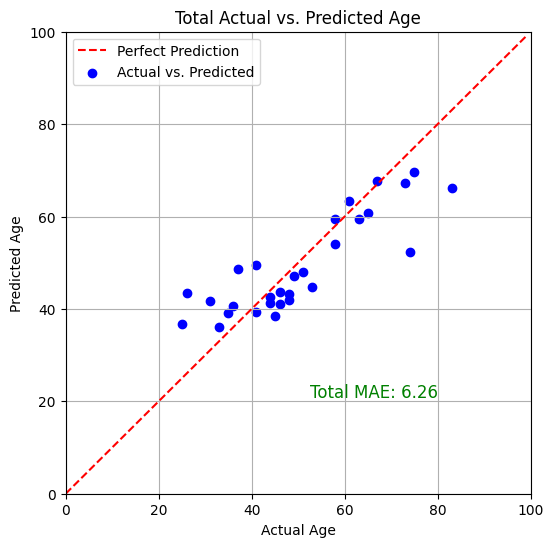

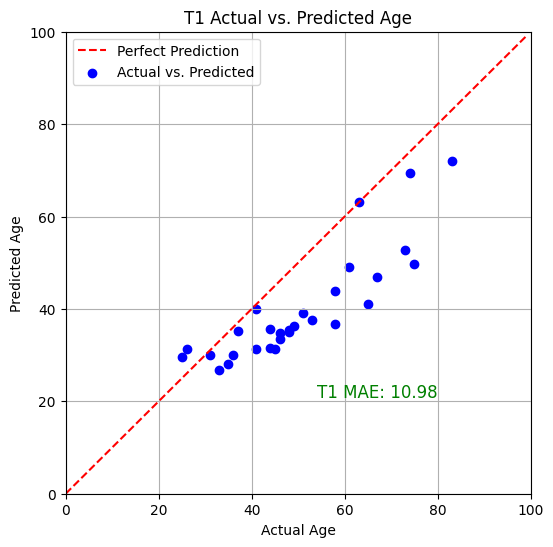

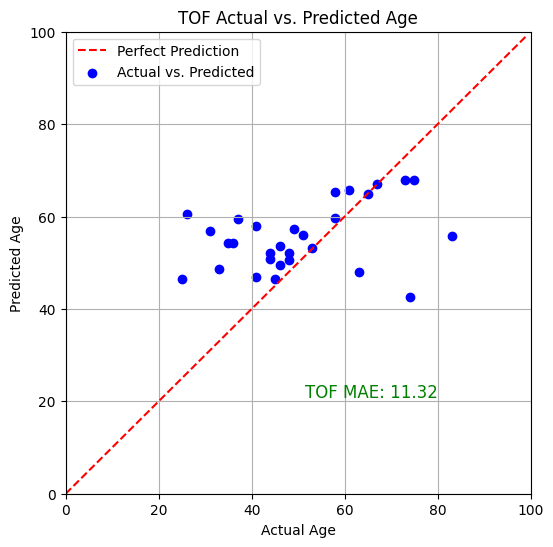

In [116]:
actual_age = np.array([]) 
total_predicted_age = np.array([])
t1_predicted_age = np.array([])
tof_predicted_age = np.array([])

t1_tof_strange_idx = []
t1_strange_idx = []
tof_strange_idx = []

model.to(device)

with torch.no_grad():
    model.eval()
    for step, batch in enumerate(t1_tof_loader):
        t1, tof, labels = batch["t1"].to(device), batch["tof"].to(device), batch["label"]
        
        bs = len(t1)
        
        t1 = t1 / t1.mean()
        tof = tof / tof.mean()
        inputs = torch.stack((t1, tof), dim=1)
        
        outputs,  t1_outputs, tof_outputs = model(inputs)
        
        x = outputs[0].detach().cpu().squeeze()
        prob = np.exp(x)
        pred = prob @ bc

        t1_r = t1_outputs[0].detach().cpu().squeeze()
        t1_prob = np.exp(t1_r.numpy())
        t1_pred = t1_prob @ bc

        tof_r = tof_outputs[0].detach().cpu().squeeze()
        tof_prob = np.exp(tof_r.numpy())
        tof_pred = tof_prob @ bc
        
        actual_age = np.append(actual_age, labels.cpu().numpy())
        total_predicted_age = np.append(total_predicted_age, pred)
        t1_predicted_age = np.append(t1_predicted_age, t1_pred)
        tof_predicted_age = np.append(tof_predicted_age, tof_pred)

        if(np.abs(pred - t1_pred) >= 10):
            t1_strange_idx.append(step)
        if(np.abs(pred - tof_pred) >= 10):
            tof_strange_idx.append(step)
        if(np.abs(t1_pred - tof_pred) >= 15):
            t1_tof_strange_idx.append(step)

    # Plot 1: Total Actual vs. Predicted Age
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(0, 100), np.arange(0, 100), linestyle='--', color='red', label='Perfect Prediction')
    plt.scatter(actual_age, total_predicted_age, color='blue', label='Actual vs. Predicted')
    plt.axis([0, 100, 0, 100])
    plt.grid('minor')
    mae_total = calculate_mae(actual_age, total_predicted_age)
    plt.text(80, 20, f'Total MAE: {mae_total:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('Total Actual vs. Predicted Age')
    plt.legend()
    # plt.savefig('./new_multi_sfcn/1/total_age.png')
    plt.show()

    # Plot 2: T1 Actual vs. Predicted Age
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(0, 100), np.arange(0, 100), linestyle='--', color='red', label='Perfect Prediction')
    plt.scatter(actual_age, t1_predicted_age, color='blue', label='Actual vs. Predicted')
    plt.axis([0, 100, 0, 100])
    plt.grid('minor')
    mae_t1 = calculate_mae(actual_age, t1_predicted_age)
    plt.text(80, 20, f'T1 MAE: {mae_t1:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('T1 Actual vs. Predicted Age')
    plt.legend()
    # plt.savefig('./new_multi_sfcn/1/t1_age.png')
    plt.show()

    # Plot 3: TOF Actual vs. Predicted Age
    plt.figure(figsize=(6, 6))
    plt.plot(np.arange(0, 100), np.arange(0, 100), linestyle='--', color='red', label='Perfect Prediction')
    plt.scatter(actual_age, tof_predicted_age, color='blue', label='Actual vs. Predicted')
    plt.axis([0, 100, 0, 100])
    plt.grid('minor')
    mae_tof = calculate_mae(actual_age, tof_predicted_age)
    plt.text(80, 20, f'TOF MAE: {mae_tof:.2f}', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.title('TOF Actual vs. Predicted Age')
    plt.legend()
    # plt.savefig('./new_multi_sfcn/1/tof_age.png')
    plt.show()


In [340]:
print(t1_tof_strange_idx)
print(t1_strange_idx)
print(tof_strange_idx)

[0, 7, 10, 14, 19, 25, 28, 36, 44, 52, 55, 67, 94, 126, 142, 148, 196, 246, 253, 269, 295, 296, 302, 314, 326, 327, 365, 397, 410]
[0, 10, 14, 44, 55, 67, 148, 149, 158, 202, 212, 246, 253, 292, 295, 296, 302, 314, 322, 324, 327, 366, 370]
[0, 7, 14, 44, 55, 67, 103, 142, 327, 365, 410]


In [341]:
def filter_data_by_indices(data_dict, indices):
    filtered_data = [data_dict[i] for i in indices]
    return filtered_data

In [342]:
t1_tof_strange_data = filter_data_by_indices(data_dict, t1_tof_strange_idx)
t1_strange_data = filter_data_by_indices(data_dict, t1_strange_idx)
tof_strange_data = filter_data_by_indices(data_dict, tof_strange_idx)
print(len(t1_tof_strange_data), len(t1_strange_data), len(tof_strange_data))

29 23 11


In [343]:
t1_tof_ds = Dataset(
    data=t1_tof_strange_data,
    transform=valid_transform,
)
t1_tof_loader = DataLoader(
    t1_tof_ds, batch_size=1, shuffle=False, 
)

In [344]:
t1_ds = Dataset(
    data=t1_strange_data,
    transform=valid_transform,
)
t1_loader = DataLoader(
    t1_ds, batch_size=1, shuffle=False, 
)

In [345]:
tof_ds = Dataset(
    data=tof_strange_data,
    transform=valid_transform,
)
tof_loader = DataLoader(
    tof_ds, batch_size=1, shuffle=False, 
)

## Data Visualization

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU CHECK : {True if device.type == 'cuda' else False}")

model = MultiSFCN()
model = torch.nn.DataParallel(model)
model = model.to(device)

model

GPU CHECK : True


DataParallel(
  (module): MultiSFCN(
    (encoder1): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

In [27]:
# model.to(device)

fp_ = './new_multi_sfcn/1/models/model_4.699.pth'

model.load_state_dict(torch.load(fp_))

<All keys matched successfully>

In [28]:
from typing import Callable, List, Tuple

import ttach as tta

from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection

class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)
    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """
    
    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        raise Exception("Not Implemented")
        
    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:
        if grads is None:
            raise ValueError("Gradients가 None입니다. 역전파가 수행되고 그래디언트가 캡처되었는지 확인하세요.")
        weights = self.get_cam_weights(input_tensor, target_layer, targets, activations, grads)
        # 2D conv
        if len(activations.shape) == 4:
            weighted_activations = weights[:, :, None, None] * activations
        # 3D conv
        elif len(activations.shape) == 5:
            weighted_activations = weights[:, :, None, None, None] * activations
        else:
            raise ValueError(f"Invalid activation shape. Get {len(activations.shape)}.")
            
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam
        
    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module], eigen_smooth: bool = False) -> np.ndarray:
        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)
        
        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]
        
        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            print(f"Loss for backward pass: {loss.item()}")  # 디버깅용 출력
            loss.backward(retain_graph=True)
        
        cam_per_layer = self.compute_cam_per_layer(input_tensor, targets, eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        
        if len(input_tensor.shape) == 4:
            width, height = input_tensor.size(-1), input_tensor.size(-2)
            return width, height
        elif len(input_tensor.shape) == 5:
            depth, width, height = input_tensor.size(-1), input_tensor.size(-2), input_tensor.size(-3)
            return depth, width, height
        elif len(input_tensor.shape) == 6:
            depth, width, height = input_tensor.size(-1), input_tensor.size(-2), input_tensor.size(-3)
            return depth, width, height
        else:
            raise ValueError("Invalid input_tensor shape. Only 2D or 3D images are supported.")

    def compute_cam_per_layer(
            self,
        input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)
        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]
            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])
        return cam_per_target_layer
        
    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)
        
    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)
            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)
            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)
        cam = np.mean(np.float32(cams), axis=0)
        return cam
        
    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)
        return self.forward(input_tensor,
                            targets, eigen_smooth)
        
    def __del__(self):
        self.activations_and_grads.release()
        
    def __enter__(self):
        return self
        
    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

In [29]:
class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)
        
    def get_cam_weights(self, input_tensor, target_layer, target_category, activations, grads):
        if grads is None:
            raise ValueError("Gradients가 None입니다. 역전파가 수행되고 그래디언트가 캡처되었는지 확인하세요.")
        
        # 2D 이미지
        if len(grads.shape) == 4:
            return np.mean(grads, axis=(2, 3))
    
        # 3D 이미지
        elif len(grads.shape) == 5:
            return np.mean(grads, axis=(2, 3, 4))
    
        else:
            raise ValueError("잘못된 grads 형식. grads의 형식은 4(2D 이미지) 또는 5(3D 이미지)여야 합니다.")


In [30]:
import math
from typing import Dict, List

import cv2
import matplotlib
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.ndimage import zoom
from torchvision.transforms import Compose, Normalize, ToTensor

In [31]:
# import nibabel as nib

# nifti_path = '/mnt/babymri/data_age_mni1mm/IXI002-Guys-0828/T1_bet.nii.gz'
# nft = nib.load(nifti_path)
# data = nft.get_fdata()

# affine=nft.affine
# header=nft.header

# for batch in train_loader:
#     x1, x2, mask, age = (batch["t1"]).to(device), (batch["tof"]).to(device), (batch["mask"]).to(device), batch["label"]

#     if age >= 60:
#         x1 = x1 / x1.mean()
#         mask_tmp = torch.tensor(mask[0, 0, :, :, :])
        
#         mask_res = np.zeros_like(mask_tmp.cpu())
#         mask_res[(mask_tmp.cpu()==17)] = 17
#         mask_res[(mask_tmp.cpu()==53)] = 53
#         nib.save(nib.Nifti1Image(mask_res, affine=affine, header=header), './T1_aseg/Hippo/Hippo_aseg_60.nii.gz')

#         mask_tmp = torch.tensor(mask[0, 0, :, :, :])
        
#         mask_res = np.zeros_like(mask_tmp.cpu())
#         mask_res[(mask_tmp.cpu()==10)] = 10
#         mask_res[(mask_tmp.cpu()==49)] = 49
#         nib.save(nib.Nifti1Image(mask_res, affine=affine, header=header), './T1_aseg/Thalamus/Thalamus_aseg_60.nii.gz')

#         mask_tmp = torch.tensor(mask[0, 0, :, :, :])
        
#         mask_res = np.zeros_like(mask_tmp.cpu())
#         mask_res[(mask_tmp.cpu()==8)] = 8
#         mask_res[(mask_tmp.cpu()==47)] = 47
#         nib.save(nib.Nifti1Image(mask_res, affine=affine, header=header), './T1_aseg/Cere_cortex/Cere_cortex_aseg_60.nii.gz')

#         mask_tmp = torch.tensor(mask[0, 0, :, :, :])
        
#         mask_res = np.zeros_like(mask_tmp.cpu())
#         mask_res[(mask_tmp.cpu()==3)] = 3
#         mask_res[(mask_tmp.cpu()==42)] = 42
#         nib.save(nib.Nifti1Image(mask_res, affine=affine, header=header), './T1_aseg/Cortex/Cortex_aseg_60.nii.gz')

#         nib.save(nib.Nifti1Image(x1[0][0].cpu(), affine=affine, header=header), './T1_aseg/T1_60.nii.gz')
    
#         break

In [32]:
def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)
    
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)
    
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.5) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")
    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)
    
def create_labels_legend(concept_scores: np.ndarray,
                         labels: Dict[int, str],
                         top_k=2):
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]
        concept_labels = []
        for category in categories:
            score = concept_scores[concept_index, category]
            label = f"{','.join(labels[category].split(',')[:3])}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk
    
def show_factorization_on_image(img: np.ndarray,
                                explanations: np.ndarray,
                                colors: List[np.ndarray] = None,
                                image_weight: float = 0.5,
                                concept_labels: List = None) -> np.ndarray:
    """ Color code the different component heatmaps on top of the image.
        Every component color code will be magnified according to the heatmap itensity
        (by modifying the V channel in the HSV color space),
        and optionally create a lagend that shows the labels.
        Since different factorization component heatmaps can overlap in principle,
        we need a strategy to decide how to deal with the overlaps.
        This keeps the component that has a higher value in it's heatmap.
    :param img: The base image RGB format.
    :param explanations: A tensor of shape num_componetns x height x width, with the component visualizations.
    :param colors: List of R, G, B colors to be used for the components.
                   If None, will use the gist_rainbow cmap as a default.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * visualization.
    :concept_labels: A list of strings for every component. If this is paseed, a legend that shows
                     the labels and their colors will be added to the image.
    :returns: The visualized image.
    """
    n_components = explanations.shape[0]
    if colors is None:
        # taken from https://github.com/edocollins/DFF/blob/master/utils.py
        _cmap = plt.cm.get_cmap('gist_rainbow')
        colors = [
            np.array(
                _cmap(i)) for i in np.arange(
                0,
                1,
                1.0 /
                n_components)]
    concept_per_pixel = explanations.argmax(axis=0)
    masks = []
    for i in range(n_components):
        mask = np.zeros(shape=(img.shape[0], img.shape[1], 3))
        mask[:, :, :] = colors[i][:3]
        explanation = explanations[i]
        explanation[concept_per_pixel != i] = 0
        mask = np.uint8(mask * 255)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2HSV)
        mask[:, :, 2] = np.uint8(255 * explanation)
        mask = cv2.cvtColor(mask, cv2.COLOR_HSV2RGB)
        mask = np.float32(mask) / 255
        masks.append(mask)
    mask = np.sum(np.float32(masks), axis=0)
    result = img * image_weight + mask * (1 - image_weight)
    result = np.uint8(result * 255)
    if concept_labels is not None:
        px = 1 / plt.rcParams['figure.dpi']  # pixel in inches
        fig = plt.figure(figsize=(result.shape[1] * px, result.shape[0] * px))
        plt.rcParams['legend.fontsize'] = int(
            14 * result.shape[0] / 256 / max(1, n_components / 6))
        lw = 5 * result.shape[0] / 256
        lines = [Line2D([0], [0], color=colors[i], lw=lw)
                 for i in range(n_components)]
        plt.legend(lines,
                   concept_labels,
                   mode="expand",
                   fancybox=True,
                   shadow=True)
        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.axis('off')
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        plt.close(fig=fig)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        data = cv2.resize(data, (result.shape[1], result.shape[0]))
        result = np.hstack((result, data))
    return result
    
def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = zoom(img, [(t_s/i_s) for i_s, t_s in zip(img.shape, target_size[::-1])])
        result.append(img)
    result = np.float32(result)

    return result
    
def scale_accross_batch_and_channels(tensor, target_size):
    batch_size, channel_size = tensor.shape[:2]
    reshaped_tensor = tensor.reshape(
        batch_size * channel_size, *tensor.shape[2:])
    result = scale_cam_image(reshaped_tensor, target_size)
    result = result.reshape(
        batch_size,
        channel_size,
        target_size[1],
        target_size[0])
    return result

In [ ]:
layer = model.module.encoder2.conv_5[0]

# GradCAM 인스턴스 생성
cam = GradCAM(model=model, target_layers=[layer], use_cuda=torch.cuda.is_available())

sum_grayscale_cam = None
num_cams = 0

t1_sum_cam = None
t1_num_cams = 0

model.eval()

for step, batch in enumerate(all_loader):
    if step in t1_tof_strange_idx:
        strange_x1, strange_x2, mask, age = (batch["t1"]).to(device), (batch["tof"]).to(device), (batch["mask"]).to(device), batch["label"]
        strange_x1 = strange_x1 / strange_x1.mean()
        strange_x2 = strange_x2 / strange_x2.mean()
        x = torch.stack((strange_x1, strange_x2), dim=1)
        
        ind = [i for i in range(12, 92, 2)]
        pp = 0
        if int(age) % 2 != 0:
            pp = int(age) - 1
        else:
            pp = int(age)
        ind = ind.index(pp)
        targets = [ClassifierOutputTarget(ind)]
        
        cam.batch_size = 1
        
        try:
            grayscale_cam = cam(input_tensor=x, targets=targets)
            
            if t1_sum_cam is None:
                t1_sum_cam = grayscale_cam
            else:
                t1_sum_cam += grayscale_cam
            
            t1_num_cams += 1
        except ValueError as e:
            print(e)
    else:
        x1, x2, mask, age = (batch["t1"]).to(device), (batch["tof"]).to(device), (batch["mask"]).to(device), batch["label"]
        x1 = x1 / x1.mean()
        x2 = x2 / x2.mean()
        x = torch.stack((x1, x2), dim=1)
        
        ind = [i for i in range(12, 92, 2)]
        pp = 0
        if int(age) % 2 != 0:
            pp = int(age) - 1
        else:
            pp = int(age)
        ind = ind.index(pp)
        targets = [ClassifierOutputTarget(ind)]
        
        cam.batch_size = 1
        
        try:
            grayscale_cam = cam(input_tensor=x, targets=targets)
            
            if sum_grayscale_cam is None:
                sum_grayscale_cam = grayscale_cam
            else:
                sum_grayscale_cam += grayscale_cam
            
            num_cams += 1
        except ValueError as e:
            print(e)

if num_cams > 0:
    final_grayscale_cam = sum_grayscale_cam / num_cams
if t1_num_cams > 0:
    t1_final_grayscale_cam = t1_sum_cam / t1_num_cams

Loss for backward pass: -2.621751308441162
Loss for backward pass: -2.466704845428467
Loss for backward pass: -1.7977333068847656
Loss for backward pass: -2.5407400131225586
Loss for backward pass: -1.8400949239730835
Loss for backward pass: -2.3815507888793945
Loss for backward pass: -2.8862709999084473
Loss for backward pass: -2.662985324859619
Loss for backward pass: -2.280724048614502
Loss for backward pass: -2.499450922012329
Loss for backward pass: -6.27593994140625
Loss for backward pass: -2.1137266159057617
Loss for backward pass: -2.3499131202697754
Loss for backward pass: -1.6568070650100708
Loss for backward pass: -3.1242172718048096
Loss for backward pass: -1.5423862934112549
Loss for backward pass: -2.677417516708374
Loss for backward pass: -2.106090545654297
Loss for backward pass: -2.0816822052001953
Loss for backward pass: -2.280951976776123
Loss for backward pass: -1.522978663444519
Loss for backward pass: -1.991962194442749
Loss for backward pass: -2.588535785675049
L

In [ ]:
print(num_cams, t1_num_cams)

In [35]:
# final_grayscale_cam = nib.load('/home/oj/ycm/TOF_gradcam.nii.gz')
# final_grayscale_cam = final_grayscale_cam.get_fdata()
# t1_final_grayscale_cam = nib.load('/home/oj/ycm/TOF_gradcam_strange.nii.gz')
# t1_final_grayscale_cam = t1_final_grayscale_cam.get_fdata()

In [36]:
print(final_grayscale_cam.shape)
print(x2.shape)
print(mask.shape)

(160, 192, 160)
torch.Size([1, 1, 160, 192, 160])
torch.Size([1, 1, 160, 192, 160])


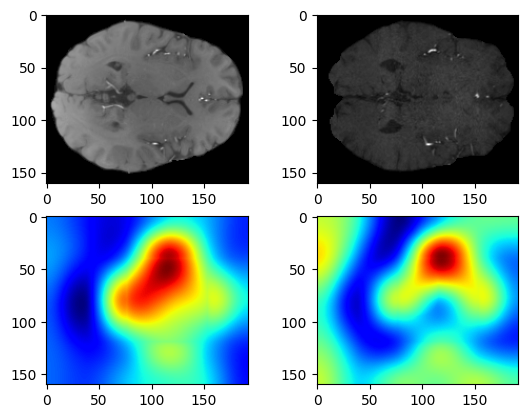

In [38]:
plt.subplot(2,2,1)
plt.imshow(x2[0, 0, :, :, 60].cpu(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(strange_x2[0, 0, :, :, 60].cpu(), cmap='gray')
plt.subplot(2,2,3)
plt.imshow(final_grayscale_cam[ :, :, 60], cmap='jet')
plt.subplot(2,2,4)
plt.imshow(t1_final_grayscale_cam[ :, :, 60], cmap='jet')
plt.show()

In [34]:
sum = np.sum(final_grayscale_cam, axis=3)
t1_sum = np.sum(t1_final_grayscale_cam, axis=3)

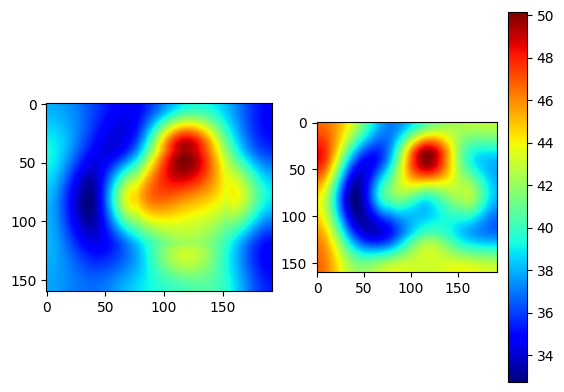

In [35]:
plt.subplot(1,2,1)
plt.imshow(sum[0,:,:], cmap='jet')
plt.subplot(1,2,2)
plt.imshow(t1_sum[0,:,:], cmap='jet')
plt.colorbar()
plt.show()

In [43]:
pwd

'/home/oj/ycm'

In [53]:
nifti_path = '/mnt/babymri/data_age_mni1mm/IXI002-Guys-0828/TOF_bet.nii.gz'
nft = nib.load(nifti_path)
data = nft.get_fdata()

affine=nft.affine
header=nft.header

nib.save(nib.Nifti1Image(final_grayscale_cam[0,:,:,:], affine=affine, header=header), '/home/oj/ycm/TOF_t1tof_gradcam.nii.gz')
nib.save(nib.Nifti1Image(t1_final_grayscale_cam[0,:,:,:], affine=affine, header=header), '/home/oj/ycm/TOF_t1tof_gradcam_strange.nii.gz')

In [55]:
nifti_path = '/home/oj/ycm/T1_gradcam_strange.nii.gz'
nft = nib.load(nifti_path)
data = nft.get_fdata()

affine=nft.affine
header=nft.header

nib.save(nib.Nifti1Image(data[0,:,:,:], affine=affine, header=header), '/home/oj/ycm/T1_gradcam_strange.nii.gz')

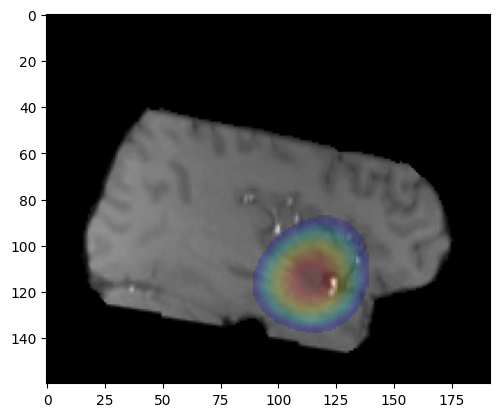

In [40]:
threshold_value = 0.2

rotated_x = np.rot90(x2[0, 0, 40, :, :].cpu(), k=1)
rotated_cam = np.rot90(final_grayscale_cam[ 40, :, :], k=1)
rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)

nonzero_indices = rotated_cam_threshold != 0

plt.figure()
plt.imshow(rotated_x, cmap='gray')
plt.imshow(np.ma.masked_where(~nonzero_indices, rotated_cam), cmap='jet', alpha=0.2)
plt.show()

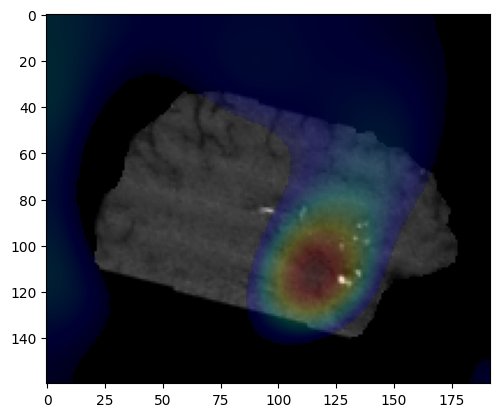

In [41]:
threshold_value = 0.27

rotated_x = np.rot90(strange_x2[0, 0, 40, :, :].cpu(), k=1)
rotated_cam = np.rot90(t1_final_grayscale_cam[ 40, :, :], k=1)
rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)

nonzero_indices = rotated_cam_threshold != 0

plt.figure()
plt.imshow(rotated_x, cmap='gray')
plt.imshow(np.ma.masked_where(~nonzero_indices, rotated_cam), cmap='jet', alpha=0.2)
plt.show()

In [ ]:
import nibabel as nib

cam_nft = nib.load('./GradCam/T1/T1_20_final_grayscale_cam.nii.gz')
final_grayscale_cam = cam_nft.get_fdata()

print(final_grayscale_cam.shape)

x1 = nib.load('./T1_bet_cropped.nii.gz')
x1 = x1.get_fdata()
print(x1.shape)

In [ ]:
import numpy as np

mask_values = mask.flatten()
unique_values = np.unique(mask_values)

print("mask 배열의 값들:")
print(unique_values)
# [ 0.  2.  3.  4.  5.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18. 24. 26.
#  28. 41. 42. 43. 44. 46. 47. 49. 50. 51. 52. 53. 54. 58. 60.]

## Mask 만들기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_rows = 6
num_cols = 6
num_slices = num_rows * num_cols

threshold_value = 0.1

plt.figure(figsize=(20, 20))
for i in range(num_slices):
    slice_num = i * 5

    if slice_num > 155:
        break

    rotated_x = np.rot90(x1[0, 0, :, :, slice_num], k=1)
    rotated_mask = np.rot90(mask[0, 0, :, :, slice_num], k=1)
    rotated_cam = np.rot90(final_grayscale_cam[0, :, :, slice_num], k=1)
    rotated_cam_threshold = np.where(rotated_cam > threshold_value, 100, 0)

    overlapping_indices = (rotated_cam_threshold == 100)
    
    overlapping_mask_values = rotated_mask.copy()
    overlapping_mask_values[~overlapping_indices] = 0

    if overlapping_mask_values.size > 0:
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(rotated_x, cmap='gray')
        plt.imshow(overlapping_mask_values, cmap="jet",alpha=0.2)
        plt.title(f'Slice {slice_num}')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import nibabel as nib

nifti_path = '/mnt/babymri/data_age_mni1mm/IXI002-Guys-0828/T1_bet.nii.gz'
nft = nib.load(nifti_path)
data = nft.get_fdata()

affine=nft.affine
header=nft.header

th = 0.1

mask_tmp = torch.tensor(mask[0, 0, :, :, :])
cam_tmp = torch.tensor(final_grayscale_cam[0])
cam_threshold = np.where(cam_tmp > th, 1, 0)

overlapping_indices = (cam_threshold == 1)

overlapping_masks = mask_tmp
overlapping_masks[~overlapping_indices] = 0

print(overlapping_masks.shape)

mask_values = overlapping_masks.flatten()
unique_values = np.unique(mask_values.cpu())

print("mask 배열의 값들:")
print(unique_values)

nib.save(nib.Nifti1Image(overlapping_masks.cpu(), affine=affine, header=header), './GradCam/T1/60_T1_freesurf_old_segmask.nii.gz')

## 시각화

In [ ]:
import nibabel as nib

cam_nft = nib.load('./GradCam/T1/T1_20_final_grayscale_cam.nii.gz')
final_grayscale_cam = cam_nft.get_fdata()

print(final_grayscale_cam.shape)
x1 = nib.load('./T1_bet_cropped.nii.gz')
x1 = x1.get_fdata()
print(x1.shape)

for batch in train_loader:
    x2, mask, age = (batch["tof"]).to(device), (batch["mask"]).to(device), batch["label"]
    break

# mask = nib.load('./GradCam/T1/20_T1_freesurf_segmask.nii.gz')
# mask = mask.get_fdata()
# print(mask.shape)

In [ ]:
threshold_value = 0.095

rotated_x = np.rot90(x1[:, :, 50], k=1)
rotated_mask = np.rot90(mask[0,0,:, :, 50], k=1)
rotated_cam = np.rot90(final_grayscale_cam[:, :, 50], k=1)
rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)

overlapping_indices = (rotated_mask != 0) & (rotated_cam_threshold != 0)

masked_cam = np.ma.masked_where(~overlapping_indices, rotated_cam)

plt.imshow(rotated_x, cmap='gray')
plt.imshow(masked_cam, cmap='jet', alpha=0.2)
plt.axis('off')

In [ ]:
threshold_value = 0.1

rotated_x = np.rot90(x1[:, 65, :], k=1)
rotated_mask = np.rot90(mask[0,0,:, 65, :], k=1)
rotated_cam = np.rot90(final_grayscale_cam[:, 65, :], k=1)
rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)

overlapping_indices = (rotated_mask != 0) & (rotated_cam_threshold != 0)

masked_cam = np.ma.masked_where(~overlapping_indices, rotated_cam)

plt.imshow(rotated_x, cmap='gray')
plt.imshow(masked_cam, cmap='jet', alpha=0.2)
plt.axis('off')

In [ ]:
threshold_value = 0.1

rotated_x = np.rot90(x1[75, :, :], k=1)
rotated_mask = np.rot90(mask[0,0,75, :, :], k=1)
rotated_cam = np.rot90(final_grayscale_cam[75, :, :], k=1)
rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)

overlapping_indices = (rotated_mask != 0) & (rotated_cam_threshold != 0)

masked_cam = np.ma.masked_where(~overlapping_indices, rotated_cam)

plt.imshow(rotated_x, cmap='gray')
plt.imshow(masked_cam, cmap='jet', alpha=0.2)
plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_rows = 6
num_cols = 6
num_slices = num_rows * num_cols

threshold_value = 0.095

plt.figure(figsize=(20, 20))
for i in range(num_slices):
    slice_num = i * 5

    if slice_num > 155:
        break

    rotated_x = np.rot90(x1[:, :, slice_num], k=1)
    rotated_mask = np.rot90(mask[0,0,:, :, slice_num], k=1)
    rotated_cam = np.rot90(final_grayscale_cam[:, :, slice_num], k=1)
    rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)

    overlapping_indices = (rotated_mask != 0) & (rotated_cam_threshold != 0)
    
    masked_cam = np.ma.masked_where(~overlapping_indices, rotated_cam)

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(rotated_x, cmap='gray')
    plt.imshow(masked_cam, cmap='jet', alpha=0.2)
    plt.title(f'Slice {slice_num}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

num_rows = 7
num_cols = 7
num_slices = num_rows * num_cols

threshold_value = 0.1

plt.figure(figsize=(20, 20))
for i in range(num_slices):
    slice_num = 10 + i * 5

    if slice_num > 190:
        break
    
    rotated_x = np.rot90(x1[:, slice_num, :], k=1)
    rotated_mask = np.rot90(mask[0, 0, :, slice_num, :], k=1)
    rotated_cam = np.rot90(final_grayscale_cam[:, slice_num, :], k=1)
    rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)
    
    overlapping_indices = (rotated_mask != 0) & (rotated_cam_threshold != 0)
    
    masked_cam = np.ma.masked_where(~overlapping_indices, rotated_cam)
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(rotated_x, cmap='gray')
    plt.imshow(masked_cam, cmap='jet', alpha=0.2)
    plt.title(f'Slice {slice_num}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

num_rows = 6
num_cols = 6
num_slices = num_rows * num_cols

threshold_value = 0.1

plt.figure(figsize=(20, 20))
for i in range(num_slices):
    slice_num = i * 5

    if slice_num > 155:
        break
    
    rotated_x = np.rot90(x1[slice_num, :, :], k=1)
    rotated_mask = np.rot90(mask[0, 0, slice_num, :, :], k=1)
    rotated_cam = np.rot90(final_grayscale_cam[slice_num, :, :], k=1)
    rotated_cam_threshold = np.where(rotated_cam < threshold_value, 0, rotated_cam)
    
    overlapping_indices = (rotated_mask != 0) & (rotated_cam_threshold != 0)
    
    masked_cam = np.ma.masked_where(~overlapping_indices, rotated_cam)
    
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(rotated_x, cmap='gray')
    plt.imshow(masked_cam, cmap='jet', alpha=0.2)
    plt.title(f'Slice {slice_num}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import nibabel as nib

nifti_path = '/mnt/babymri/data_age_mni1mm/IXI002-Guys-0828/T1_bet.nii.gz'
nft = nib.load(nifti_path)
data = nft.get_fdata()

affine=nft.affine
header=nft.header

nib.save(nib.Nifti1Image(final_grayscale_cam[0], affine=affine, header=header), './GradCam/T1/T1_old_train_final_grayscale_cam.nii.gz')


In [ ]:
print(final_grayscale_cam[0].shape)

In [ ]:
import nibabel as nib

nifti_path = '/mnt/babymri/data_age_mni1mm/IXI002-Guys-0828/T1_bet.nii.gz'
nft = nib.load(nifti_path)
data = nft.get_fdata()
print(data.shape)
affine=nft.affine
header=nft.header

# cropper = CenterSpatialCrop(roi_size=(160, 192, 160))
# resampled_data = cropper(np.expand_dims(data, axis=0))

# resampled_nifti = nib.Nifti1Image(resampled_data, affine=nft.affine, header=nft.header)
# nib.save(resampled_nifti, 'T1_bet_cropped.nii.gz')

tmp = nib.load('./GradCam/T1/T1_old_train_final_grayscale_cam.nii.gz')
tmpd = tmp.get_fdata()

threshold_value = 0.07
mask = np.where(tmpd > threshold_value, 1, 0)
print(mask.shape)

nib.save(nib.Nifti1Image(mask, affine=affine, header=header), './GradCam/T1/T1_old_train_cam_mask.nii.gz')

In [ ]:
import nibabel as nib

nifti_path = '/mnt/babymri/data_age_mni1mm/IXI002-Guys-0828/T1_bet.nii.gz'
nft = nib.load(nifti_path)
data = nft.get_fdata()
print(data.shape)
affine=nft.affine
header=nft.header

# cropper = CenterSpatialCrop(roi_size=(160, 192, 160))
# resampled_data = cropper(np.expand_dims(data, axis=0))

# resampled_nifti = nib.Nifti1Image(resampled_data, affine=nft.affine, header=nft.header)
# nib.save(resampled_nifti, 'T1_bet_cropped.nii.gz')

tmp = nib.load('./GradCam/T1/T1_young_train_final_grayscale_cam.nii.gz')
tmpd = tmp.get_fdata()

threshold_value = 0.07
mask = np.where(tmpd > threshold_value, 1, 0)

nib.save(nib.Nifti1Image(mask, affine=affine, header=header), './GradCam/T1/T1_young_train_cam_mask.nii.gz')

In [ ]:
# import numpy as np
# import nibabel as nib

# m1 = nib.load('./20_cam_mask.nii.gz')
# m2 = nib.load('./40_cam_mask.nii.gz')
# m3 = nib.load('./60_cam_mask.nii.gz')

# affine = m1.affine
# header = m1.header

# data1 = m1.get_fdata()
# data2 = m2.get_fdata()
# data3 = m3.get_fdata()

# total_mask_data = np.zeros_like(data1)

# total_mask_data[data1 > 0] = 1
# total_mask_data[data2 > 0] = 2
# total_mask_data[data3 > 0] = 3

# nib.save(nib.Nifti1Image(total_mask_data, affine=affine, header=header), 'total_mask.nii.gz')


In [ ]:
import numpy as np
import nibabel as nib

m1 = nib.load('./GradCam/T1/T1_young_train_cam_mask.nii.gz')
m2 = nib.load('./GradCam/T1/T1_old_train_cam_mask.nii.gz')

affine = m1.affine
header = m1.header

data1 = m1.get_fdata()
print(data1.shape)
data2 = m2.get_fdata()
print(data2.shape)

total_mask_data = np.zeros_like(data1)

total_mask_data[data1 > 0] = 1
total_mask_data[data2 > 0] = 2

nib.save(nib.Nifti1Image(total_mask_data, affine=affine, header=header), './GradCam/T1/T1_train_two_range_mask.nii.gz')


## Volume 구하기

In [ ]:
left_list = []
right_list = []
vol_list = []
age_list = []
img_list = []

left_label = 3
right_label = 42

cnt = 0

for step, batch in enumerate(train_loader):
    x1, x2, mask, age = (batch["t1"]).to(device), (batch["tof"]).to(device), (batch["mask"]).to(device), batch["label"]
    img_name = train_Data[step]['t1']
    nft = nib.load(img_name)
    
    affine=nft.affine
    header=nft.header
    voxel_size = nft.header.get_zooms()
    if age >= 18:
        x1 = x1 / x1.mean()
        x2 = x2 / x2.mean()
        x = torch.stack((x1, x2), dim=1)
        
        ind = [i for i in range(12, 92, 2)]
        pp = 0
        if int(age) % 2 != 0:
            pp = int(age) - 1
        else:
            pp = int(age)
        ind = ind.index(pp)
        targets = [ClassifierOutputTarget(ind)]
        
        cam = GradCAM(model=model, target_layers=[layer])
        cam.batch_size = 1
        grayscale_cam = cam(input_tensor=x, targets=targets)

        th = 0.1

        mask_tmp = torch.tensor(mask[0, 0, :, :, :])
        cam_tmp = torch.tensor(grayscale_cam[0])
        cam_threshold = np.where(cam_tmp > th, 1, 0)
        
        overlapping_indices = (cam_threshold == 1)
        
        overlapping_masks = mask_tmp
        overlapping_masks[~overlapping_indices] = 0
        
        mask_values = overlapping_masks.flatten()
        unique_values = np.unique(mask_values.cpu())

        unique_values = unique_values.astype(int)
        
        # print("mask 배열의 값들:")
        # print(unique_values)

        mask_tmp = torch.tensor(mask[0, 0, :, :, :])

        left_vol = 0.
        right_vol = 0.
        flag = 0

        for num in unique_values:
            if num == left_label or num == right_label:
                left_mask = np.zeros_like(mask_tmp.cpu())
                left_mask[(mask_tmp.cpu()==left_label)] = 1
                left_vol = left_mask.sum() * voxel_size[0] * voxel_size[1] * voxel_size[2]
                right_mask = np.zeros_like(mask_tmp.cpu())
                right_mask[(mask_tmp.cpu()==right_label)] = 1
                right_vol = right_mask.sum() * voxel_size[0] * voxel_size[1] * voxel_size[2]
                total_vol = left_vol + right_vol
                flag = 1
                break
            else:
                continue
        if flag == 1:
            left_list.append(left_vol)
            right_list.append(right_vol)
            vol_list.append(total_vol)
            age_list.append(age)
            img_list.append(img_name)



In [ ]:
age_list = [int(age.item()) for age in age_list]
print(age_list)

In [ ]:
print(left_list[2])
print(right_list[2])
print(vol_list[2])
print(age_list[2])
print(img_list[2])

In [ ]:
print(len(vol_list))

In [ ]:
combined = list(zip(age_list, img_list, vol_list))

combined.sort()

sorted_age_list, sorted_img_list, sorted_vol_list = zip(*combined)

sorted_age_list = list(sorted_age_list)
sorted_img_list = list(sorted_img_list)
sorted_vol_list = list(sorted_vol_list)

In [ ]:
new_img_list = []
for path in sorted_img_list:
    target_part = path.split('/')[-2]
    new_img_list.append(target_part)

In [ ]:
import pandas as pd

# 데이터 프레임 생성
data = {
    'age': sorted_age_list,
    'cortex_vol': sorted_vol_list
}

df = pd.DataFrame(data)

# new_img_list를 인덱스로 설정
df.set_index(pd.Index(new_img_list), inplace=True)

# 데이터프레임을 CSV 파일로 저장
df.to_csv('./Cortex_sorted_data.csv')


In [ ]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("hippo_sorted_data.csv")

# age와 hippocampus_vol 열을 추출하여 리스트에 저장
sorted_age_list = df['age'].tolist()
sorted_vol_list = df['hippocampus_vol'].tolist()

# 결과 확인
print("Sorted Age List:", sorted_age_list)
print("Sorted Volume List:", sorted_vol_list)


In [ ]:
import numpy as np

# Scatter plot 그리기
plt.scatter(sorted_age_list, sorted_vol_list, label='Volume')

# Volume 변화량 계산
volume_changes = [sorted_vol_list[i+1] - sorted_vol_list[i] for i in range(len(sorted_vol_list)-1)]

# Age와 Volume 변화량으로 선형 근사 계산
x = np.array(sorted_age_list[:-1])
y = np.array(volume_changes)
p = np.polyfit(sorted_age_list, sorted_vol_list, 1)

# Age 범위 생성
x_range = np.linspace(min(x), max(x), 100)

# 선형 근사에 따른 y 값 생성
y_fit = np.polyval(p, x_range)

# 부드럽게 그려진 선 그래프 추가
plt.plot(x_range, y_fit, '-r', label='Trendline')

# 그래프 제목, 라벨 등 추가
plt.title('Hippo Volumes')
plt.xlabel('Age')
plt.ylabel('Volume')
plt.legend()

# 그래프 출력
plt.show()


In [ ]:
import pandas as pd

# CSV 파일 읽기 (파일 이름을 "data.csv"로 가정)
df = pd.read_csv('./Volume_sort/hippo_sorted_data.csv')

# 각 연령대별 부피의 평균값을 계산
age_20_39 = df[(df['age'] >= 20) & (df['age'] <= 39)]['hippocampus_vol'].mean()
age_40_59 = df[(df['age'] >= 40) & (df['age'] <= 59)]['hippocampus_vol'].mean()
age_60_plus = df[df['age'] >= 60]['hippocampus_vol'].mean()

# 평균값 출력
print(f"20-39세의 부피 평균값: {age_20_39}")
print(f"40-59세의 부피 평균값: {age_40_59}")
print(f"60세 이상의 부피 평균값: {age_60_plus}")


In [ ]:
import pandas as pd

# CSV 파일 읽기 (파일 이름을 "data.csv"로 가정)
df = pd.read_csv('./Volume_sort/thalamus_sorted_data.csv')

# 각 연령대별 부피의 평균값을 계산
age_20_39 = df[(df['age'] >= 20) & (df['age'] <= 39)]['thalamus_vol'].mean()
age_40_59 = df[(df['age'] >= 40) & (df['age'] <= 59)]['thalamus_vol'].mean()
age_60_plus = df[df['age'] >= 60]['thalamus_vol'].mean()

# 평균값 출력
print(f"20-39세의 부피 평균값: {age_20_39}")
print(f"40-59세의 부피 평균값: {age_40_59}")
print(f"60세 이상의 부피 평균값: {age_60_plus}")


In [ ]:
import pandas as pd

# CSV 파일 읽기 (파일 이름을 "data.csv"로 가정)
df = pd.read_csv('./Volume_sort/Cortex_sorted_data.csv')

# 각 연령대별 부피의 평균값을 계산
age_20_39 = df[(df['age'] >= 20) & (df['age'] <= 39)]['cortex_vol'].mean()
age_40_59 = df[(df['age'] >= 40) & (df['age'] <= 59)]['cortex_vol'].mean()
age_60_plus = df[df['age'] >= 60]['cortex_vol'].mean()

# 평균값 출력
print(f"20-39세의 부피 평균값: {age_20_39}")
print(f"40-59세의 부피 평균값: {age_40_59}")
print(f"60세 이상의 부피 평균값: {age_60_plus}")


In [ ]:
import pandas as pd

# CSV 파일 읽기 (파일 이름을 "data.csv"로 가정)
df = pd.read_csv('./Volume_sort/Cere_Cortex_sorted_data.csv')

# 각 연령대별 부피의 평균값을 계산
age_20_39 = df[(df['age'] >= 20) & (df['age'] <= 39)]['cortex_vol'].mean()
age_40_59 = df[(df['age'] >= 40) & (df['age'] <= 59)]['cortex_vol'].mean()
age_60_plus = df[df['age'] >= 60]['cortex_vol'].mean()

# 평균값 출력
print(f"20-39세의 부피 평균값: {age_20_39}")
print(f"40-59세의 부피 평균값: {age_40_59}")
print(f"60세 이상의 부피 평균값: {age_60_plus}")
